In [1]:
import torch
import triton
import triton.language as tl
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

## Original

In [2]:
class RotaryPositionEmbedding(torch.nn.Module):
    """
    Implements Rotary Position Embedding from https://arxiv.org/abs/2104.09864.
    """
    def __init__(
        self,
        dim: int,
        rotary_percent: float = 1.0,
        seq_len_interpolation_factor: Optional[int] = None,
        pretrained_max_position_embeddings: Optional[int] = None,
    ):
        """
        Parameters
        ----------
        dim: int
            rotary embedding dimension
        rotary_percent: float
            Percent of rotary dimension to use for rotary position embeddings.
        seq_len_interpolation_factor: int
            if not None, discrete positions will be interpolated by this factor via the trick in
            https://arxiv.org/abs/2306.15595
        pretrained_max_position_embeddings: int
            pre-trained max_position_embeddings before position interpolation
        """
        super().__init__()
        if rotary_percent < 1.0:
            dim = int(dim * rotary_percent)
        self.seq_len_interpolation_factor = seq_len_interpolation_factor
        inv_freq = 1.0 / (
            10000
            ** (
                torch.arange(0, dim, 2, dtype=torch.float32, device=torch.cuda.current_device())
                / dim
            )
        )
        self.register_buffer('inv_freq', inv_freq)
        self.pretrained_max_position_embeddings = pretrained_max_position_embeddings

    def forward(self, max_seq_len: int, offset: int = 0):
        """
        Create rotary position embedding frequencies

        Parameters
        ----------
        max_seq_len: int
            sequence length of a sample
        offset: int, default = 0
            fixed offset for freqencies
        """
        seq = (
            torch.arange(max_seq_len, device=self.inv_freq.device, dtype=self.inv_freq.dtype)
            + offset
        )

        if (self.pretrained_max_position_embeddings is not None
            and self.seq_len_interpolation_factor is not None):
            if (max_seq_len >
                self.pretrained_max_position_embeddings * self.seq_len_interpolation_factor):
                # dynamic linear scaling (length > position we have learned)
                seq *= 1 / (max_seq_len / self.pretrained_max_position_embeddings)
            else:
                # fixed linear scaling
                seq *= 1 / self.seq_len_interpolation_factor

        freqs = torch.einsum('i , j -> i j', seq, self.inv_freq)
        # first part even vector components, second part odd vector components,
        #  2 * dim in dimension size
        emb = torch.cat((freqs, freqs), dim=-1)
        # emb [seq_length, .., dim]
        return emb.reshape(emb.size(0), 1, 1, emb.size(1))

In [3]:
def _rotate_half(x: torch.Tensor) -> torch.Tensor:
    """
    change sign so the last dimension becomes [-odd, +even]
    """
    x = x.view(x.shape[:-1] + torch.Size((2, x.shape[-1] // 2)))
    x1, x2 = x.unbind(dim=-2)
    return torch.cat((-x2, x1), dim=-1)




## Triton

### Implementation

In [15]:
def precompute_freqs_cis_pytorch(dim: int, end: int, theta: float = 10000.0):
    assert dim % 2 == 0

    # Generate a sequence of numbers from 0 to dim in steps of 2
    sequence = torch.arange(0, dim, 2, dtype=torch.float32, device="cuda")

    # Keep only the first half of the sequence (in case dim is odd?)
    # sequence = sequence[: (dim // 2)]

    # Calculate frequency values based on the sequence and theta
    freqs = 1.0 / (theta ** (sequence / dim))

    # Create a tensor of numbers from 0 to end, it represents the position ids
    t = torch.arange(end, device=freqs.device)

    # Generate a table of frequency values
    freqs = t[:, None] * freqs[None, :]  # torch.outer(t, freqs).float()

    # Calculate cosine and sine values for the frequencies
    # These can be considered as the real and imaginary parts of complex numbers
    freqs_cos = torch.cos(freqs)
    freqs_sin = torch.sin(freqs)

    # Return the cosine and sine values as two separate tensors
    return freqs_cos, freqs_sin

def apply_rotary_emb_pytorch(x: torch.Tensor, freq_cos: torch.Tensor, freq_sin: torch.Tensor) -> torch.Tensor:
    # Split x and x into real and imaginary parts
    x_real = x[..., 0::2]
    x_imag = x[..., 1::2]

    # Reshape freq_cos and freq_sin for broadcasting
    freq_cos = reshape_for_broadcast(freq_cos, x_real).to(torch.float32)
    freq_sin = reshape_for_broadcast(freq_sin, x_imag).to(torch.float32)

    # Perform the equivalent of complex multiplication
    x_out_real = x_real * freq_cos - x_imag * freq_sin
    x_out_imag = x_real * freq_sin + x_imag * freq_cos

    # Combine real and imaginary parts back into the original tensor
    x_out = torch.stack((x_out_real, x_out_imag), dim=-1).flatten(-2)

    return x_out.type_as(x)

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1]), f"{freqs_cis.shape} != {(x.shape[1], x.shape[-1])}"
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


In [16]:
batch, seq_len, heads, dim = [1, 16, 32, 128]

embeddings_load = torch.randn([batch, seq_len, heads * dim], dtype=torch.float16, device="cuda")
rms_weights = torch.randn([heads * dim], dtype=torch.float16, device="cuda") * 0.2
q_weights_load = torch.randn([heads * dim, heads * dim], dtype=torch.float16, device="cuda") * 0.2

In [17]:
@triton.jit
def get_freq_multi_tokens(offs_cn, starting_idx, theta: tl.constexpr, NB_TOKENS: tl.constexpr):
    DIM: tl.constexpr = 128  # in model, dim = self.params.dim // self.params.n_heads
    freqs = offs_cn % DIM
    freqs = freqs.to(tl.float32) / DIM
    freqs = tl.math.pow(theta, freqs)
    freqs = (tl.arange(0, NB_TOKENS) + starting_idx)[:, None] / freqs[None, :]
    return tl.cos(freqs), tl.sin(freqs)

In [18]:
@triton.jit
def rbe_triton(x_ptr, out_ptr,
               M, K,
               stride_x_batch, stride_x_m, stride_x_n,
               stride_out_batch, stride_out_m, stride_out_n,
               start_token_position,
               THETA: tl.constexpr, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr):
    pid_batch = tl.program_id(axis=0)
    pid = tl.program_id(axis=1)
    pid_m = pid // tl.cdiv(K, BLOCK_SIZE_K)
    pid_n = pid % tl.cdiv(K, BLOCK_SIZE_K)

    offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = pid_n * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K // 2) * 2  # take only even numbers
    x_ptrs = x_ptr + (pid_batch * stride_x_batch + stride_x_m * offs_m[:, None] + stride_x_n * offs_n[None, :])
    x_real_mask = (offs_m[:, None] < M) & (offs_n[None, :] < K)
    real = tl.load(x_ptrs, mask=x_real_mask, other=0.0)
    x_imag_mask = (offs_m[:, None] < M) & (1 + offs_n[None, :] < K)
    imag = tl.load(x_ptrs + 1, mask=x_imag_mask, other=0.0)
    tl.debug_barrier()
    start_block = start_token_position + pid_m * BLOCK_SIZE_M
    cos, sin = get_freq_multi_tokens(offs_cn=offs_n, starting_idx=start_block, theta=THETA, NB_TOKENS=BLOCK_SIZE_M)

    out_real = real * cos - imag * sin
    out_imag = real * sin + imag * cos
    tl.debug_barrier()
    out_ptrs = out_ptr + (
            pid_batch * stride_out_batch + stride_out_m * offs_m[:, None] + stride_out_n * offs_n[None, :])
    out_real_mask = (offs_m[:, None] < M) & (offs_n[None, :] < K)
    tl.store(out_ptrs, out_real, mask=out_real_mask)
    out_imag_mask = (offs_m[:, None] < M) & (1 + offs_n[None, :] < K)
    tl.store(out_ptrs + 1, out_imag, mask=out_imag_mask)

@triton.jit
def rbe_triton_backward(x_ptr, out_ptr,
               M, K,
               stride_x_batch, stride_x_m, stride_x_n,
               stride_out_batch, stride_out_m, stride_out_n,
               start_token_position,
               THETA: tl.constexpr, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr):
    pid_batch = tl.program_id(axis=0)
    pid = tl.program_id(axis=1)
    pid_m = pid // tl.cdiv(K, BLOCK_SIZE_K)
    pid_n = pid % tl.cdiv(K, BLOCK_SIZE_K)

    offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = pid_n * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K // 2) * 2  # take only even numbers
    x_ptrs = x_ptr + (pid_batch * stride_x_batch + stride_x_m * offs_m[:, None] + stride_x_n * offs_n[None, :])
    x_real_mask = (offs_m[:, None] < M) & (offs_n[None, :] < K)
    real = tl.load(x_ptrs, mask=x_real_mask, other=0.0)
    x_imag_mask = (offs_m[:, None] < M) & (1 + offs_n[None, :] < K)
    imag = tl.load(x_ptrs + 1, mask=x_imag_mask, other=0.0)
    tl.debug_barrier()
    start_block = start_token_position + pid_m * BLOCK_SIZE_M
    cos, sin = get_freq_multi_tokens(offs_cn=offs_n, starting_idx=start_block, theta=THETA, NB_TOKENS=BLOCK_SIZE_M)

    out_real = real * cos + imag * sin
    out_imag = -real * sin + imag * cos
    tl.debug_barrier()
    out_ptrs = out_ptr + (
            pid_batch * stride_out_batch + stride_out_m * offs_m[:, None] + stride_out_n * offs_n[None, :])
    out_real_mask = (offs_m[:, None] < M) & (offs_n[None, :] < K)
    tl.store(out_ptrs, out_real, mask=out_real_mask)
    out_imag_mask = (offs_m[:, None] < M) & (1 + offs_n[None, :] < K)
    tl.store(out_ptrs + 1, out_imag, mask=out_imag_mask)

In [19]:
def rbe_triton_wrapper(x: torch.Tensor, pos: int) -> torch.Tensor:
    batch, M, K = x.shape
    out = torch.empty_like(x)
    grid = lambda META: (
        batch, triton.cdiv(META["M"], META["BLOCK_SIZE_M"]) * triton.cdiv(META["K"], META["BLOCK_SIZE_K"]),)

    rbe_triton[grid](x, out,
                     M, K,
                     *x.stride(),
                     *out.stride(),
                     start_token_position=pos, THETA=10000., BLOCK_SIZE_M=2, BLOCK_SIZE_K=1024)
    return out

def rbe_triton_wrapper_backward(x: torch.Tensor, pos: int) -> torch.Tensor:
    batch, M, K = x.shape
    out = torch.empty_like(x)
    grid = lambda META: (
        batch, triton.cdiv(META["M"], META["BLOCK_SIZE_M"]) * triton.cdiv(META["K"], META["BLOCK_SIZE_K"]),)

    rbe_triton_backward[grid](x, out,
                     M, K,
                     *x.stride(),
                     *out.stride(),
                     start_token_position=pos, THETA=10000., BLOCK_SIZE_M=2, BLOCK_SIZE_K=1024)
    return out, None, None,

### 점검 -> 통과

In [20]:
xq = embeddings_load @ q_weights_load.t()
xq = xq.view(batch, seq_len, heads, dim)


xq_output_triton = embeddings_load  @ q_weights_load.t()
out_rbe_triton = rbe_triton_wrapper(xq_output_triton, pos=0).view(batch, seq_len, heads, dim)

freq_cos, freq_sin = precompute_freqs_cis_pytorch(dim=128, end=seq_len)
out_rbe_pytorch = apply_rotary_emb_pytorch(x=xq, freq_cos=freq_cos, freq_sin=freq_sin).view(batch, seq_len, heads, dim)

assert torch.allclose(out_rbe_pytorch, out_rbe_triton, atol=1e-1), f"max diff: {torch.max(torch.abs(out_rbe_pytorch - out_rbe_triton))}"
print("rbe triton", triton.testing.do_bench(lambda: rbe_triton_wrapper(xq_output_triton, pos=0)))
print("rbe pytorch", triton.testing.do_bench(lambda: apply_rotary_emb_pytorch(x=xq, freq_cos=freq_cos, freq_sin=freq_sin)))


rbe triton 0.016656363382935524
rbe pytorch 0.062155671417713165


In [21]:
class FusedRoPEFunc(torch.autograd.Function):
    """
    Function for FusedRoPE

    This implementation assumes the input tensor to be in `sbhd`, `bshd` or `thd` format and
    the RoPE tensor to be of shape (s, 1, 1, d). It accepts arbitrary memory layouts to avoid
    the expensive `.contiguous()` calls, thus it may not achieve the best memory access pattern.
    """

    @staticmethod
    def forward(
        ctx,
        t: torch.Tensor,
        freqs: torch.Tensor,
        tensor_format: str = "bshd",
        cu_seqlens: Union[torch.Tensor, None] = None,
    ) -> torch.Tensor:
        if tensor_format == "sbhd":
            s,b,h,d = t.shape
            output = rbe_triton_wrapper(t.transpose(0, 1).view(b,s,h*d), pos= 0).view(b,s,h,d).transpose(0, 1)
        elif tensor_format == "bshd":
            b,s,h,d = t.shape

            output = rbe_triton_wrapper(
                t.view(b,s,h*d),  pos= 0
            ).view(b,s,h,d)
        # elif tensor_format == "thd":
        #     output = tex.fused_rope_thd_forward(t, cu_seqlens, freqs)
        else:
            raise ValueError(f"Unsupported tensor_format: {tensor_format}.")
        ctx.save_for_backward(freqs, cu_seqlens)
        ctx.tensor_format = tensor_format

        return output

    @staticmethod
    def backward(
        ctx, grad_output: torch.Tensor
    ) -> Tuple[Union[torch.Tensor, None], ...]:
        freqs, cu_seqlens = ctx.saved_tensors
        if ctx.tensor_format == "sbhd":
            s,b,h,d = grad_output.shape
            grad_input = rbe_triton_wrapper_backward(grad_output.transpose(0, 1).view(b,s,h*d), pos= 0)[0].view(b,s,h,d).transpose(0, 1)
        elif ctx.tensor_format == "bshd":
            b,s,h,d = grad_output.shape
            grad_input = rbe_triton_wrapper(
                grad_output.view(b,s,h*d), pos= 0
            )[0].view(b,s,h,d)
        # elif ctx.tensor_format == "thd":
        #     grad_input = tex.fused_rope_thd_backward(grad_output, cu_seqlens, freqs)
        else:
            raise ValueError(f"Unsupported tensor_format: {ctx.tensor_format}.")

        return grad_input, None, None, None, None

In [22]:
def apply_rotary_pos_emb(
    t: torch.Tensor,
    freqs: torch.Tensor,
    tensor_format: str = "sbhd",
    fused: bool = False,
    cu_seqlens: Union[torch.Tensor, None] = None,
) -> torch.Tensor:
    """
    Apply rotary positional embedding tensor to the input tensor.

    Parameters
    ----------
    t: torch.Tensor
        Input tensor of shape `[s, b, h, d]`, `[s, b, h, d]` or `[t, h, d]`, on which
        rotary positional embedding will be applied.
    freqs: torch.Tensor
        Rotary positional embedding tensor of shape `[s2, 1, 1, d2]` and dtype 'float',
        with `s2 >= s` and `d2 <= d`.
    fused: bool, default = False
        Whether to use a fused applying RoPE implementation.
    tensor_format: {'sbhd', 'bshd', 'thd'}, default = 'sbhd'
        is `bshd` if `t` is of shape `[bs, seq, ...]`, or `sbhd` if `t` is
        of shape `[seq, bs, ...]`. 'thd' is only supported when `fused` is True.
    cu_seqlens: torch.Tensor, default = None.
        Cumulative sum of sequence lengths in a batch for `t`, with shape [b + 1] and
        dtype torch.int32. Only valid when `tensor_format` is 'thd'.
    """
    if fused:
        assert (
            tensor_format != "thd" # or cu_seqlens is not None
        ), "tensor_format should not be 'thd'."
        return FusedRoPEFunc.apply(t, freqs, tensor_format, cu_seqlens)

    assert tensor_format in ("sbhd", "bshd"), (
        "Only formats `sbhd` or `bshd` are supported for input tensor `t` "
        f"when fused is False, got {tensor_format}."
    )

    max_seq_len = freqs.shape[0]
    cur_seq_len = t.shape[1] if tensor_format == "bshd" else t.shape[0]

    # Only apply the rotary embeddings up to the sequence length of the running
    # input.
    assert cur_seq_len <= max_seq_len, (
        f"Rotary Embeddings only supported up to {max_seq_len} sequence length!"
    )
    freqs = freqs[:cur_seq_len]
    if tensor_format == "bshd":
        freqs = freqs.transpose(0, 1)  # [seq, 1, 1, dim] -> [1, seq, 1, dim]
    # cos/sin first then dtype conversion for better precision
    cos_ = torch.cos(freqs).to(t.dtype)
    sin_ = torch.sin(freqs).to(t.dtype)

    rot_dim = freqs.shape[-1]
    # ideally t_pass is empty so rotary pos embedding is applied to all tensor t
    t, t_pass = t[..., :rot_dim], t[..., rot_dim:]

    # first part is cosine component
    # second part is sine component, need to change signs with _rotate_half method
    t = (t * cos_) + (_rotate_half(t) * sin_)
    return torch.cat((t, t_pass), dim=-1)

### Test 함수

In [23]:
def test_fused_rope(
    dtype: torch.dtype,
    seq_length: int,
    hidden_size: int,
    rotary_percent: float,
    margin: int,
    transpose: Union[Tuple, None],
    tensor_format: str,
    loss_func: Callable,

) -> None:
    device = torch.device("cuda:0")
    batch_size, head_num = 2, 64
    t = torch.rand(
        (seq_length - margin, batch_size, head_num, hidden_size),
        dtype=dtype,
        device=device,
    )
    if tensor_format == "bshd":
        t = t.transpose(0, 1).contiguous()
    if transpose:
        t = t.transpose(*transpose).contiguous().transpose(*transpose)
    t.requires_grad = True

    rotary_pos_emb = RotaryPositionEmbedding(hidden_size, rotary_percent)
    emb = rotary_pos_emb(seq_length)


    # unfused
    output_unfused = apply_rotary_pos_emb(
        t,
        emb,
        tensor_format=tensor_format,
        fused=False
    )
    loss_unfused = loss_func(output_unfused)
    loss_unfused.backward()
    grad_unfused = t.grad.detach().clone()
    t.grad = None


    # fused
    output_fused = apply_rotary_pos_emb(
        t,
        emb,
        tensor_format=tensor_format,
        fused=True,
    )
    loss_fused = loss_func(output_fused)
    loss_fused.backward()
    grad_fused = t.grad.detach().clone()
    t.grad = None

    torch.testing.assert_close(output_fused, output_unfused, **get_tol(dtype))
    torch.testing.assert_close(grad_fused, grad_unfused, **get_tol(dtype))
    assert output_fused.is_contiguous()


In [27]:
# Gradient is a broadcasted scalar
def _overlapping_grad(output: torch.Tensor) -> torch.Tensor:
    return output.sum() * 2

# Gradient is a full tensor
def _non_overlapping_grad(output: torch.Tensor) -> torch.Tensor:
    t = torch.ones_like(output)
    return torch.sum(output * t)

def get_tol(dtype: torch.dtype) -> Dict:
    if dtype == torch.bfloat16:
        return dict(atol=1e-2, rtol=1e-2)
    elif dtype == torch.float16:
        return dict(atol=1e-3, rtol=1e-3)
    return dict(atol=1e-5, rtol=1.3e-6)


### 결과 비교
테스트 함수에서 다른 결과가 나오는 문제 발생...

In [28]:
rotary_pos_emb = RotaryPositionEmbedding(dim)
emb = rotary_pos_emb(seq_len)
test_input = torch.randn([batch, seq_len, heads , dim], dtype=torch.float16, device="cuda")
out_rbe_triton = apply_rotary_pos_emb(test_input, emb, tensor_format= 'sbhd', fused = True).view(batch, seq_len, heads, dim)
out_rbe_pytorch = apply_rotary_pos_emb(test_input, emb, tensor_format= 'sbhd', fused = False).view(batch, seq_len, heads, dim)
torch.testing.assert_close(out_rbe_triton, out_rbe_pytorch, **get_tol(torch.float16)) # 이 결과는 동일한데..

In [29]:
test_fused_rope(torch.float16, 1024, 128, 1.0, 0, None, "sbhd", _overlapping_grad)

AssertionError: Tensor-likes are not close!

Mismatched elements: 16656072 / 16777216 (99.3%)
Greatest absolute difference: 2.79296875 at index (490, 1, 7, 91) (up to 0.001 allowed)
Greatest relative difference: inf at index (1, 1, 25, 7) (up to 0.001 allowed)

### 속도 비교

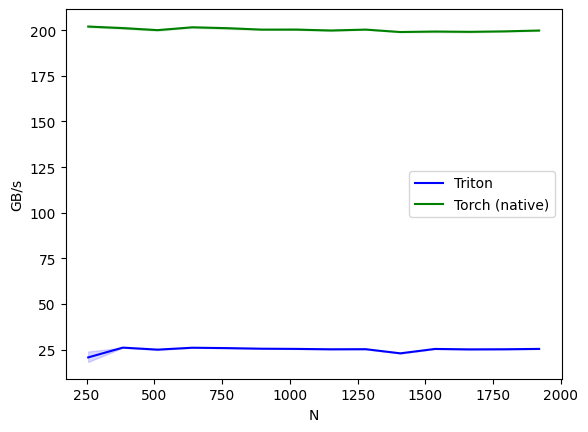

RoPE-performance:
         N     Triton  Torch (native)
0    256.0  20.787783      201.993981
1    384.0  26.144517      201.128691
2    512.0  25.043844      200.033580
3    640.0  26.086072      201.590592
4    768.0  25.880261      201.109794
5    896.0  25.550808      200.303785
6   1024.0  25.440984      200.307018
7   1152.0  25.232118      199.838726
8   1280.0  25.289317      200.324003
9   1408.0  23.017107      198.999748
10  1536.0  25.429889      199.273285
11  1664.0  25.179261      199.109545
12  1792.0  25.245914      199.354122
13  1920.0  25.444337      199.818675


In [30]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 16)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="RoPE-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(N, M, 64, 1, device='cuda', dtype=torch.float32)
    x = x.transpose(0, 1).contiguous()
    rotary_pos_emb = RotaryPositionEmbedding(1, 0.5)
    emb = rotary_pos_emb(4096)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: apply_rotary_pos_emb(x, emb, fused = False), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: apply_rotary_pos_emb(x, emb, fused = True), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)